In [1]:
##########################################################
############         LOAD MODULES           ##############
##########################################################
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import model_selection
from sklearn import metrics

***       INITIAL DISCUSSION      ***

The data provided were MIDI audio files with the majority categorized into 4 composers (PS1) and the rest uncategorized (PS2), of which only 3 did not belong to the 4 composers.  The project goal was to determine which PS2 files were NOT composed by the 4 composers which partitioned the PS1 data.

This brings us to the first potential concern, our goal is to develop a binary classifier but our known data to use for training only contains 'successes' and no 'failures'.

There are a few immediate options that jump out to me to approach this.  The first, which has been pursued here, is to use a one-class classifier, of which I chose the one-class Support Vector Machine (SVM).  This was chosen as it was the most referenced approach in my quick search of one-class classifiers, is based off of SVM, which is relatively easy to understand conceptually and some of the major drawbacks (not suitable for large training sets or with a high number of features relative to the size of the dataset) are not issues in this self-contained toy problem and is relatively easy to set-up and iterate on.

I will discuss the other options and the potential issues with extending the SVM approach later on.

In [2]:
##########################################################
############           LOAD DATA             #############
##########################################################

##################    TRAINING DATA     ##################
data = pickle.load(open('ps1Dataset.p','rb'))

##################     TESTING DATA     ##################
dataTest = pickle.load(open('ps2Dataset.p','rb'))
dataTest30 = pickle.load(open('ps2Dataset-30.p', 'rb'))

***       DATA PROCESSING AND ORGANIZATION      ***

The MIDI data was processed in a separate file (MidiProcessing.ipynb) and two datasets were generated, one based off the PS1 data and one from the PS2 data.

The PS1 data is treated as training data and the PS2 data as test data.  Since the test data is uncategorized, the PS1 data is split into training and validation data, which will also allow for hyperparameter tuning for the SVM model.  The splitting is done through a Stratified K-Fold approach, using the Composer classification in the PS1 data as the stratification variable.  5 K-Folds were used as the smallest group (Brahms) has only 20 MIDI files and this allows for a larger Brahms sample in the validation set.  A sensitivity study to the number of K-Folds would be a good idea, but was not carried out here.

In [3]:
##########################################################
###########      DEFINE HELPER FUNCTIONS       ###########
##########################################################

# Partition the data into KFold splits for analysis
# allowing for stratification based on Composer
def applyKFold(data, split=5):
    if ('composer' in data):
        composer = data.pop('Composer')
        skf = model_selection.StratifiedKFold(n_splits=split, shuffle=True)
        data = pickle.load(open('ps1Dataset.p','rb'))
        return skf.split(data, composer)
    else:
        kf = model_selection.KFold(n_splits=split, shuffle=True)
        return kf.split(data)

    
# Build one class SVM model and return model and performance metrics
# assuming Train/Validate/Test datasets provided
def oneClassSVM(nu=0.5, gamma=0.1, train=None, val=None, test=None, forAgg=False):
    # Fit the model
    clf = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=gamma).fit(train)

    # Evaluate the model
    predTrain = clf.predict(train) 
    predValidate = clf.predict(val)
    predTest = clf.predict(test)

    # Analyze model Performance
    perfTrain = calcPerfMetrics(predTrain, clf.decision_function(train))
    perfValidate = calcPerfMetrics(predValidate, clf.decision_function(val))
    perfTest = calcPerfMetrics(predTest, clf.decision_function(test))

    # Return model performance data
    if (forAgg):
        # When we are running multiple k-folds, we need to return raw data to be 
        # processed as an aggregation of all runs
        return {'predTrain': predTrain, 'distTrain': clf.decision_function(train), 
                'predVal': predValidate, 'distVal': clf.decision_function(val),
                'predTest': predTest, 'distTest': clf.decision_function(test)}        
    else:
        # Summary data for each iteration of the model
        return generateMetricsVector(nu, gamma, perfTrain, perfValidate, perfTest, clf)

    
# Based on the SVM model applied to train/val/test data, determine some performance metrics     
def calcPerfMetrics(predDataset, clfDist):
    predErrors = predDataset[predDataset == -1].size/len(predDataset)

    # Separate positive from negative cases and look at some simple statistics
    distTrainPosMean = np.array(clfDist[clfDist > 0.0]).mean()
    distTrainNegMean = np.array(clfDist[clfDist < 0.0]).mean()
    distTrainPosStd = np.array(clfDist[clfDist > 0.0]).std()
    distTrainNegStd = np.array(clfDist[clfDist < 0.0]).std()

    return {'predErrors': predErrors, 'posMean': distTrainPosMean, 'negMean': distTrainNegMean,
            'posStd': distTrainPosStd, 'negStd': distTrainNegStd} 


# Helper function to store performance data in a vector for easy comparisons across models
def generateMetricsVector(nu, gamma, perfTrain, perfVal, perfTest, clf=None):
    
    return [nu, gamma, perfTrain['predErrors'], perfVal['predErrors'], perfTest['predErrors'], 
            perfTrain['posMean'], perfTrain['posStd'], perfTrain['negMean'], perfTrain['negStd'],
            perfVal['posMean'], perfVal['posStd'], perfVal['negMean'], perfVal['negStd'],
            perfTest['posMean'], perfTest['posStd'], perfTest['negMean'], perfTest['negStd'],clf]    


# Evaluation metrics names for return vector from oneClassSVM
names = ['nu', 'gamma', 'trainErrPct', 'valErrPct', 'testOutlierPct', 'trainPosAvg', 'trainPosStd', 
         'trainNegAvg', 'trainNegStd', 'valPosAvg', 'valPosStd', 
         'valNegAvg', 'valNegStd', 'testPosAvg', 'testPosStd', 
         'testNegAvg', 'testNegStd', 'model']

In [4]:
##########################################################
###########           USER SETTINGS            ###########
##########################################################

## Specify features to include
featureSubset = ['numInstruments','pitchRange','meanDuration','coeffvarDuration']

## Specify desired kfolds (must be at least 2)
folds = 5

## Specify SVM parameters
nu = 0.5
gamma = 0.25

##########################################################
###########  INITIAL MODEL USING SOME DEFAULTS  ##########
##########################################################

## Define datasets
## PS2 - 3 'correct' outliers, but don't know which ones
test = dataTest[featureSubset]  

## PS1 - add back in composer to use as class in stratified KFold sampling
featureSubset.insert(0, 'Composer')

## Apply KFold to break test PS1 test dataset into a test/validation set
splits = applyKFold(data[featureSubset], split=folds)

## FIXME: This is really hacky, there is definitely a better way to manage this
featureSubset.remove('Composer')

## Loop through the test/val folds and generate the model andd evaluate performance
foldData = []
metrics = []
for train, validate in splits:
    # metrics for each KFold instance
    foldData.append(oneClassSVM(nu=nu, gamma=gamma, train=data[featureSubset].loc[train], 
                             val=data[featureSubset].loc[validate], test=test, forAgg=False))
    
    # rawdata for aggregation below
    metrics.append(oneClassSVM(nu=nu, gamma=gamma, train=data[featureSubset].loc[train], 
                               val=data[featureSubset].loc[validate], test=test, forAgg=True))

## Calculate the aggregated performance quantities    
perfTrain = calcPerfMetrics(np.concatenate([item['predTrain'] for item in metrics]),
                np.concatenate([item['distTrain'] for item in metrics]))

perfValidate = calcPerfMetrics(np.concatenate([item['predVal'] for item in metrics]),
                np.concatenate([item['distVal'] for item in metrics]))

perfTest = calcPerfMetrics(np.concatenate([item['predTest'] for item in metrics]),
                np.concatenate([item['distTest'] for item in metrics]))

## Save the performance quantities
analysis = generateMetricsVector(nu, gamma, perfTrain, perfValidate, perfTest)

In [5]:
##########################################################
###########      INITIAL MODEL PERFORMANCE      ##########
##########################################################

# individual runs in a dataFrame table
display(pd.DataFrame(foldData, columns=names))

# aggregrated results in a pandas series
pd.Series(analysis, index=names)

,nu,gamma,trainErrPct,valErrPct,testOutlierPct,trainPosAvg,trainPosStd,trainNegAvg,trainNegStd,valPosAvg,valPosStd,valNegAvg,valNegStd,testPosAvg,testPosStd,testNegAvg,testNegStd,model
0,0.5,0.25,0.503106,0.658537,0.657143,0.098013,0.088908,-0.532032,0.632342,0.115638,0.088791,-0.698038,0.846611,0.138475,0.103790,-0.866567,0.769074,OneClassSVM(gamma=0.25)
1,0.5,0.25,0.496894,0.609756,0.628571,0.078989,0.091022,-0.552456,0.694826,0.099920,0.092676,-0.672151,0.787579,0.112347,0.099963,-0.856091,0.894379,OneClassSVM(gamma=0.25)
2,0.5,0.25,0.487654,0.675000,0.657143,0.100861,0.102438,-0.632069,0.793495,0.142614,0.137924,-1.221768,1.048524,0.122015,0.115549,-1.132791,1.119717,OneClassSVM(gamma=0.25)
3,0.5,0.25,0.512346,0.450000,0.685714,0.095635,0.089688,-0.486386,0.613292,0.092914,0.054725,-0.780932,0.845331,0.141139,0.084951,-0.856095,0.887902,OneClassSVM(gamma=0.25)
4,0.5,0.25,0.500000,0.600000,0.685714,0.098437,0.099804,-0.482594,0.620326,0.107492,0.091441,-1.224805,1.219402,0.137310,0.110455,-0.880215,0.833666,OneClassSVM(gamma=0.25)


nu                0.500000
gamma             0.250000
trainErrPct       0.500000
valErrPct         0.599010
testOutlierPct    0.662857
trainPosAvg       0.094404
trainPosStd       0.094945
trainNegAvg      -0.536348
trainNegStd       0.675467
valPosAvg         0.109081
valPosStd         0.094092
valNegAvg        -0.926369
valNegStd         0.999958
testPosAvg        0.129650
testPosStd        0.104200
testNegAvg       -0.918023
testNegStd        0.914311
model                  NaN
dtype: float64

***       DISCUSSION FOR THE INITIAL MODEL      ***

The one-class SVM was run using effectively default settings, $\nu=0.5, \gamma=0.25$, where the $\gamma$ value was set to 1/numFeatures (here is 4).  For the one-class SVM, the Radial Basis Function (rbf) kernel is typically used for novelty detection (classification using 1-sided training data) and will be used here.
(https://scikit-learn.org/stable/modules/outlier_detection.html#novelty-detection) 

There are a few key metrics here, we will focus on the `trainErrPct, valErrPct and testOutlierPct`.  These are the percentage of MIDI files identified as NOT belonging to the 4 composers ('failure') $$ \frac{not(Bach, Beethoven, Schubert, Brahms)}{files\ analyzed}$$ in each of the respective datasets (train, validation and test).

For the train and validation sets, all MIDI files belong to one of these composers and thus the true number of failures in these dataset should be 0 (i.e, `trainErrPct = 0, valErrPct = 0`).

Here we have `trainErrPct` $\approx 50\%$, so basically the partition has been drawn to allow for half of the accurate entries to fall outside the decision boundary.  This setup almost certainly will lead to a useless algorithm and the `valErrPct` $\approx 60\%$ seems to suggest that.

We will ignore the performance on the test dataset (PS2) and the additional metrics here as the model seems quite poor.

It would seem we would want to decrease the training error in the train dataset and that is precisely what the $\nu$ parameter controls and despite $0.25$ being the default value, a smaller value of $\nu$ is probably optimal.  $\gamma$ determines how much space is around each data point, with high values leading to overfitting of the training data and low values leading to the entire space being constrained within the 'success' region.

This would suggest some tuning of the hyperparameters is needed here.

In [6]:
##########################################################
#######    MANUAL GRID SEARCH OF HYPERPARAMETERS    ######
##########################################################

## Specify features to include
featureSubset = ['numInstruments','pitchRange','meanDuration','coeffvarDuration']

## Specify desired kfolds (must be at least 2)
folds = 5

## Specify SVM parameters
nus = np.arange(0.02,0.22,0.02)
gammas = np.arange(0.02,0.22,0.02)

analysis = []
for nu in nus:
    for gamma in gammas:
        ## Define datasets
        ## PS2 - 3 'correct' outliers, but don't know which ones
        test = dataTest[featureSubset]  

        ## PS1 - add back in composer to use as class in stratified KFold sampling
        featureSubset.insert(0, 'Composer')

        ## Apply KFold to break test PS1 test dataset into a test/validation set
        splits = applyKFold(data[featureSubset], split=folds)

        ## FIXME: This is really hacky, there is definitely a better way to manage this
        featureSubset.remove('Composer')

        ## Loop through the test/val folds and generate the model andd evaluate performance
        metrics = []
        for train, validate in splits:
            # rawdata for aggregation below
            metrics.append(oneClassSVM(nu=nu, gamma=gamma, train=data[featureSubset].loc[train], 
                                       val=data[featureSubset].loc[validate], test=test, forAgg=True))

        ## Calculate the aggregated performance quantities    
        perfTrain = calcPerfMetrics(np.concatenate([item['predTrain'] for item in metrics]),
                        np.concatenate([item['distTrain'] for item in metrics]))

        perfValidate = calcPerfMetrics(np.concatenate([item['predVal'] for item in metrics]),
                        np.concatenate([item['distVal'] for item in metrics]))

        perfTest = calcPerfMetrics(np.concatenate([item['predTest'] for item in metrics]),
                        np.concatenate([item['distTest'] for item in metrics]))

        ## Save the performance quantities
        analysis.append(generateMetricsVector(nu, gamma, perfTrain, perfValidate, perfTest))

In [7]:
analysisDF = pd.DataFrame(analysis, columns=names)
analysisDF

,nu,gamma,trainErrPct,valErrPct,testOutlierPct,trainPosAvg,trainPosStd,trainNegAvg,trainNegStd,valPosAvg,valPosStd,valNegAvg,valNegStd,testPosAvg,testPosStd,testNegAvg,testNegStd,model
0,0.02,0.02,0.070545,0.153465,0.142857,0.021327,0.020111,-0.000207,0.000146,0.024403,0.021126,-0.023600,0.031695,0.026832,0.019627,-0.005458,0.010712,None
1,0.02,0.04,0.090347,0.178218,0.165714,0.012820,0.011886,-0.000196,0.000133,0.013800,0.011992,-0.026749,0.034749,0.016669,0.011621,-0.011036,0.014449,None
2,0.02,0.06,0.112624,0.232673,0.200000,0.008986,0.009044,-0.000218,0.000151,0.010434,0.009602,-0.026251,0.040915,0.011339,0.008970,-0.010958,0.012274,None
3,0.02,0.08,0.134901,0.272277,0.222857,0.007038,0.007578,-0.000175,0.000139,0.007998,0.007389,-0.025917,0.034488,0.008279,0.007127,-0.012819,0.014551,None
4,0.02,0.10,0.164604,0.272277,0.291429,0.005643,0.006274,-0.000202,0.000140,0.006664,0.007010,-0.028005,0.040583,0.006877,0.006115,-0.013304,0.015954,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.20,0.12,0.236386,0.361386,0.354286,0.054033,0.057539,-0.062694,0.127394,0.067643,0.060978,-0.235280,0.354683,0.071577,0.052712,-0.193017,0.175212,None
96,0.20,0.14,0.228960,0.356436,0.360000,0.049635,0.053009,-0.051392,0.103899,0.059762,0.051050,-0.242527,0.319222,0.064916,0.047481,-0.215918,0.177804,None
97,0.20,0.16,0.230198,0.405941,0.365714,0.046259,0.050571,-0.031127,0.079637,0.061262,0.053357,-0.235560,0.343059,0.059191,0.048127,-0.215797,0.194190,None
98,0.20,0.18,0.225248,0.440594,0.400000,0.042794,0.047702,-0.021170,0.054805,0.052449,0.046836,-0.250717,0.330064,0.058447,0.046219,-0.227017,0.211950,None


***       HYPERPARAMETER TUNING      ***

To search for optimal values of $\nu$ and $\gamma$ I setup a manual grid search over the range from $0.02$ to $0.20$, stepping by $0.02$ in both parameters.  While using a scikit built in grid search or other approach will potentially lead to a better solution, due to a lack of experience using those features and the complication of having only a single class in the training groups, I opted for a manual search here instead.  This will allow me to understand the relationship between the hyperparameters and the accuracy metrics in the training and validation sets, while allowing my intuition to guide where to set cutoffs.

The table above summarizes the 100 runs that were conducted.  Let's start by examining the data a bit.

In the below figures we show the percentage error in training (left) and validation (right) as a function of $\nu$ (top) and $\gamma$ (bottom).  While we could drive these errors down to 0, which would be accurate, since they should all be classified as 'success', that will be overfit and will undoubtedly perform extremely poorly on the test dataset (PS2).

We can see that as both $\nu \rightarrow 0$ and $\gamma \rightarrow 0$, both training and validation errors decrease.  This suggests that smaller values of these parameters will be optimal here.

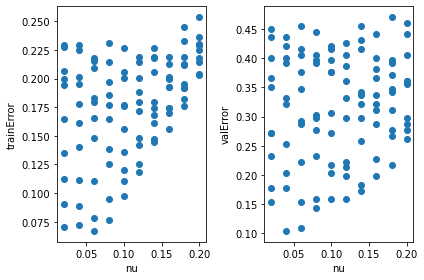

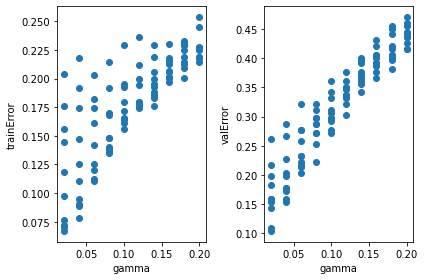

In [8]:
fig, axs = plt.subplots(1,2)
axs[0].scatter(analysisDF['nu'],analysisDF['trainErrPct'])
axs[0].set(xlabel='nu',ylabel='trainError')
axs[1].scatter(analysisDF['nu'],analysisDF['valErrPct'])
axs[1].set(xlabel='nu',ylabel='valError')
fig.tight_layout()
plt.show()

fig, axs = plt.subplots(1,2)
axs[0].scatter(analysisDF['gamma'],analysisDF['trainErrPct'])
axs[0].set(xlabel='gamma',ylabel='trainError')
axs[1].scatter(analysisDF['gamma'],analysisDF['valErrPct'])
axs[1].set(xlabel='gamma',ylabel='valError')
fig.tight_layout()
plt.show()

***   HYPERPARAMETER TUNING  CONT'D    ***

It may also be important to understand how far from the success region are the improperly classified MIDI files in the training and validation sets?  We look at this below where we have the average distance from the success region in the training sets (left) and validation sets (right) vs $\nu$ (top) and $\gamma$ (bottom), respectively.

From this we can see that lower values of $\nu$ and higher values of $\gamma$ lead to smaller average errors in the training set.  This implies that low values of $\nu$ and high values of $\gamma$ probably suffer from overfitting, as the success region is tightly packed around the data, such that the improperly classified files just barely fall outside the region.  We see that this has a similar behavior for $\nu$ in the training set, but there doesn't seem to be as strong a relationship with $\gamma$ in the validation set.

Putting these all together, our goal seems to be to lower the errors in the training and validation sets, while attempting to avoid overfitting, and thus having a chance at a meaningful prediction model on unseen data.

So let's define some arbitrary cutoffs for this exercise based on this data exploration.  We don't want to get all the training data properly classified, as that most likely leads to overfitting and poor performance on the PS2 dataset.  So let's say we want to misclassify around $5-10\%$ of the training data.  This restricts $\nu <= 0.1$ and $\gamma <= 0.05$.

Next, let's say we want to allow for some larger errors, but try not to have them be too large in the training set, this suggest $\nu$ and $\gamma$ should be closer to the top of their ranges, so let's pick tuned values of $\nu = 0.1, \gamma = 0.05$.

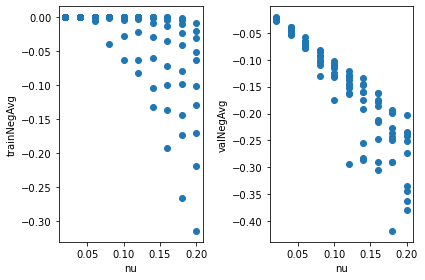

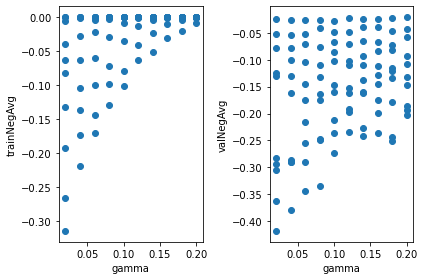

In [9]:
fig, axs = plt.subplots(1,2)
axs[0].scatter(analysisDF['nu'],analysisDF['trainNegAvg'])
axs[0].set(xlabel='nu',ylabel='trainNegAvg')
axs[1].scatter(analysisDF['nu'],analysisDF['valNegAvg'])
axs[1].set(xlabel='nu',ylabel='valNegAvg')
fig.tight_layout()
plt.show()

fig, axs = plt.subplots(1,2)
axs[0].scatter(analysisDF['gamma'],analysisDF['trainNegAvg'])
axs[0].set(xlabel='gamma',ylabel='trainNegAvg')
axs[1].scatter(analysisDF['gamma'],analysisDF['valNegAvg'])
axs[1].set(xlabel='gamma',ylabel='valNegAvg')
fig.tight_layout()
plt.show()

In [10]:
##########################################################
###########     TUNED HYPERPARAMETER MODEL      ##########
##########################################################

## Specify features to include
featureSubset = ['numInstruments','pitchRange','meanDuration','coeffvarDuration']

## Specify SVM parameters
nu = 0.1
gamma = 0.05

## Define datasets
## PS2 - 3 'correct' outliers, but don't know which ones
test = dataTest[featureSubset]  

## Loop through the test/val folds and generate the model andd evaluate performance
analysis = oneClassSVM(nu=nu, gamma=gamma, train=data[featureSubset], 
                         val=data[featureSubset], test=test, forAgg=False)

analysisRaw = oneClassSVM(nu=nu, gamma=gamma, train=data[featureSubset], 
                         val=data[featureSubset], test=test, forAgg=True)

In [12]:
##########################################################
###########       TUNED MODEL PERFORMANCE       ##########
##########################################################

# aggregrated results in a pandas series
pd.Series(analysis, index=names)

# individual runs in a dataFrame table
testNot = pd.Series(analysisRaw['distTest'])
indices = testNot.loc[testNot < 0.0].index
notDF = dataTest.loc[indices][['Piece']]
notDF['dist'] = testNot[indices]
notDF

,Piece,dist
9,1054314,-0.060918
12,3443286,-0.105512
25,6743813,-0.000071
27,6764841,-0.010830
33,9481313,-0.042833


***   TUNED MODEL RESULTS    ***

Using the hyperparameter values of $\nu = 0.1, \gamma = 0.05$, I re-trained the SVM model on the full dataset and this time applied the model's performance to the unclassified files in the PS2 Dataset.  

Based on this model, $\approx 14\% \ (5)$ of the files in PS2 were determined to NOT belong to the 4 Composers (Bach, Beethoven, Brahms, Schubert), corresponding to the following files in PS2, ordered by farthest distance from the success region's boundary:

- 0.36321860283443286_adj.mid
- 0.981087291054314_adj.mid
- 0.07186746659481313_adj.mid
- 0.06402123326764841_adj.mid
- 0.539512676743813_adj.mid

As only 3 MIDI files are actually not by the 4 composers, we certainly have at least some false positives (in the sense that files that are by the composers have been identified as NOT by them) and potentially some false negatives (in the sense that files not by the composers may have been identified as by them).


It's important to note at this point that so far the analysis on the PS2 dataset (and everything done with the PS1 dataset) was done using full MIDI files, which is not actually the scope of the problem statement.  For the problem of interest, short clips, 15, 30 or 60 seconds (with 30 being the default) of the music files are what will be provided for classification.

To assess the model performance in this case, I'll use the alternate PS2 database that I created from random 30 second extractions of the files in the PS2 database.  It would also be beneficial to check the sensitivity to re-running the SVM training and hyperparameter tuning from 30 second random extractions of the PS1 MIDI files, but due to time constraints, I am skipping that for now.  

The results of the SVM classifier on the 30 second extractions from the PS2 database are calculate below.  It shows mixed results, the positive being that 3 of the pieces determined to NOT be by the 4 composers from the full piece (shown above) are also classified as NOT being by the composer in both of the pieces 30 second extractions (0.36321860283443286_adj.mid, 0.539512676743813_adj.mid, 0.06402123326764841_adj.mid) and the other two (0.981087291054314_adj.mid, 0.07186746659481313_adj.mid), for one of their two 30 second excerpts.

However, many other pieces have now been flagged as not being by the 4 composers, with 4 having both of their 30 second exceprts identified as NOT being by one of the 4 composers:

- 0.09167358800381353_adj.mid
- 0.22047111832936942_adj.mid
- 0.337517805339117_adj.mid
- 0.905499891236923_adj.mid

and another 9 being identified with one of their excerpts.  This gets us to about half of the pieces being classified as not being by one of the 4 composers with at least one of their 30 second excerpts.  This suggests performance equivalent to random selection, although hopefully at least the 3 that are actually NOT by the composer were accurately captured.

This suggests additional refinement on the model is necessary to work with the shorter 30 second clips.

In [13]:
##########################################################
###########     TUNED HYPERPARAMETER MODEL      ##########
##########################################################

## Specify features to include
featureSubset = ['numInstruments','pitchRange','meanDuration','coeffvarDuration']

## Specify SVM parameters
nu = 0.1
gamma = 0.05

## Define datasets
## PS2 with 30 second extracts
test = dataTest30[featureSubset]  

## Loop through the test/val folds and generate the model andd evaluate performance
analysis = oneClassSVM(nu=nu, gamma=gamma, train=data[featureSubset], 
                         val=data[featureSubset], test=test, forAgg=False)

analysisRaw = oneClassSVM(nu=nu, gamma=gamma, train=data[featureSubset], 
                         val=data[featureSubset], test=test, forAgg=True)

##########################################################
###########       TUNED MODEL PERFORMANCE       ##########
##########################################################

# aggregrated results in a pandas series
pd.Series(analysis, index=names)

# individual runs in a dataFrame table
testNot = pd.Series(analysisRaw['distTest'])
indices = testNot.loc[testNot < 0.0].index
notDF = dataTest30.loc[indices][['Piece']]
notDF['dist'] = testNot[indices]
notDF

,Piece,dist
0,0481628,-0.109471
3,0381353,-1.551461
5,9531658,-0.015821
8,3719129,-0.100530
17,9481313,-0.029176
18,0381353,-0.468065
25,5879718,-0.002210
30,6743813,-0.003250
31,5339117,-0.085975
32,1236923,-0.079905


***   DISCUSSION AND FUTURE DIRECTIONS    ***

I discussed above that a few approaches to this one-sided classification problem immediately came to mind.  Outside of the one-class SVM used here, a simple solution to this would be to access additional MIDI files by alternate composers to provide a balanced set of training data.  In certain applications, this may not be suitable, but certainly for a composer classifier, there is a wealth of MIDI data available to train a more robust model from.  The MusicNet database referenced in this exercise (https://zenodo.org/record/5120004#.YkpHkjfMJoN, https://arxiv.org/pdf/1611.09827.pdf) would be one place to start as well as other music databases such as the KernScores database discussed here (https://ieeexplore.ieee.org/document/7258427, http://kern.ccarh.org/).

As more training data is added, the applicability of SVM may come into question, as one of the major drawbacks is its scaling with the size of the training data set.  This would lead to the desire for alternate ML approaches for this classification problems.  Deep learning could be a useful tool (https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5) for feature extraction from the notes data, but computational requirements are certainly a concern there as well.

Alternate approaches such as Logistic Regression or Random Forest may also be more suitable if the training datasets increase in size.


For this analysis, I ended up using a very limited set of derived features from the MIDI files.  The ideas behind these came mostly from D. Herremans et al. (https://ieeexplore.ieee.org/document/7258427) and discussions with my parents, who have both been playing classical music for most of their lives.  I created some code in the MidiProcessing file to extract frequency of types of intervals, dissonance and other features, but my approach to this analysis was not suitable except for piano data and thus was not pursued here.

One idea would be to train different models based on which instruments were present and use the appropriate model in that case, but this would also require a lot more training data to ensure sufficient data was available for the distinct cases.  Improved analysis of intervals, dissonance and other important aspects in music theory seem to be available in the music21 module (https://web.mit.edu/music21/) using the jSymbolic (https://web.mit.edu/music21/doc/moduleReference/moduleFeaturesJSymbolic.html?highlight=jsymbolic#module-music21.features.jSymbolic) features.  

The music21 module ended up being too complicated for my purposes in this small exercise, but a full understanding of the capabilities of this module and how it could help extract features from the MIDI/audio file processing would likely be beneficial to expanding the use case of this classifier.

***   A FEW FINAL COMMENTS    ***

It's clear that the current model is not a useful classifier, at least for 30 second clips, in its current state and further refinement is necessary.  I have some concerns about what the structure of the captured audio clips will be and how much of the assumed structure in the MIDI files will be able to be kept in that application.

Also, I think the model would benefit from some better derived quantities and for that some more research into music theory and some of the capabilites of music21 would be needed.

Lastly, I think the most important thing would be to expand the dataset to include training data that includes both sides of the binary classification.